Long Short Term Model

1. Make sure all packages are installed

*    !pip install numpy
*   !pip install pandas
*   !pip install os-sys
*    !pip install matplotlib
*   !pip install seaborn
*   !pip install scikit-learn
*   !pip install keras
*   !pip install tensorflow*

2. Collected Data from sensor py to this file 

Potential Issues:
 * Should AccelerationX, Y, Z still be kept in dataframe?
    inputshape is 7, not 5 
    i guess it doesn't matter bc not using chatgpt split
 * not sure why we have to reshape features twice 
 * need cat.codes and Label_Encoder, why need both?
 * would y.to_categorical be better? 

In [18]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 

In [19]:
#https://www.kaggle.com/harnoor343/fall-detection-accelerometer-data
#Link to chen hua min's code: https://www.kaggle.com/code/mmttdebbcc/notebook9689a93a64  
# create a new directory called 'kaggle_normalized', ignore it if it already exists
os.makedirs('./normalized', exist_ok=True)

labels = ['runfall', 'downSit', 'freeFall', 'runSit', 'walkFall', 'walkSit']
for label in labels:
    #read all csv files in the director "./kaggle_data/" + l, delimit by ';'
    #this is different from chen human min project
    files = glob.glob('./archive/' + label + '/*.csv')
    #assign l to to df column 'Label'
    df = pd.concat([pd.read_csv(f, sep=';') for f in files], ignore_index=True)
    # assign l to df column 'Label'
    df['Label'] = label
    # save columns 'DeviceOrientation', 'AccelerationX', 'AccelerationY', 'AccelerationZ', 'Label' to a new csv file
    df[['DeviceOrientation', 'AccelerationX', 'AccelerationY', 'AccelerationZ', 'Label']].to_csv('./normalized/' + label + '.csv', index=False)

df = pd.concat([pd.read_csv(f) for f in glob.glob('./normalized/*.csv')], ignore_index = True)
columns = ['DeviceOrientation', 'AccelerationX', 'AccelerationY', 'AccelerationZ', 'Label']




In [20]:

# for each column in 'Accerlation', 'AccelerationY', 'AccelerationZ', and a new column that is the fft of the original column
for c in ['AccelerationX', 'AccelerationY', 'AccelerationZ']:
    df[c + '_fft'] = np.fft.fft(df[c])

<AxesSubplot: >

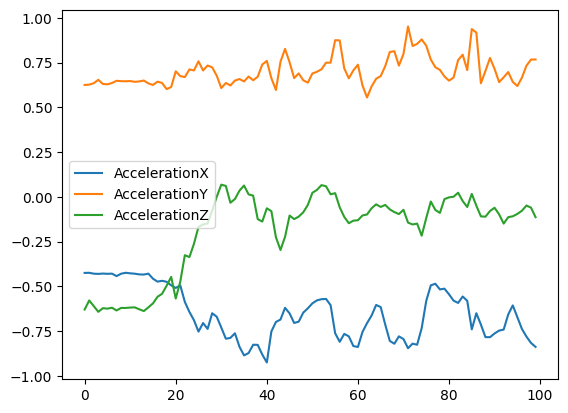

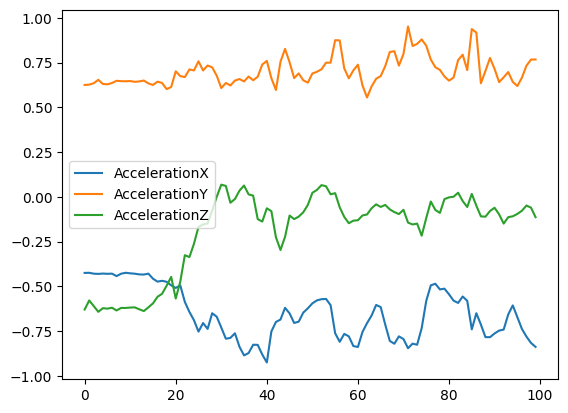

In [21]:
# plot the first 100 column 'AccelerationX' and 'AccelerationX_fft'
df[['AccelerationX', 'AccelerationY', 'AccelerationZ']].iloc[:100].plot()

# Versus Head (the same)
#df[['AccelerationX_fft', 'AccelerationY_fft', 'AccelerationZ_fft']].head(100).plot()
df[['AccelerationX', 'AccelerationY', 'AccelerationZ']].head(100).plot()

Debugging Code (Mardown Text)

 print the shape of the dataframe

              print(df.shape) 

 print each column's name in the dataframe
 
              print(df.columns)

(202599, 8)
Index(['DeviceOrientation', 'AccelerationX', 'AccelerationY', 'AccelerationZ',
       'Label', 'AccelerationX_fft', 'AccelerationY_fft', 'AccelerationZ_fft'],
      dtype='object')

In [22]:
# convert categorical data to numerical data
df['Label'] = df['Label'].astype('category')
#print(df['Label'].cat.categories)
df['Label'] = df['Label'].cat.codes

# df.head()

# convert column `DeviceOrientation` to numerical data
df['DeviceOrientation'] = df['DeviceOrientation'].astype('category')
df['DeviceOrientation'] = df['DeviceOrientation'].cat.codes
df.head()

# can you drop accx, accy, and accz?
x = np.array(df.drop(['Label'], 1)) #drops row 'Label'
y = np.array(df["Label"])

#print shape of x
print(x.shape)

import sklearn.model_selection
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x,y,test_size = 0.3)


(202599, 7)


C:\Users\siyuz\AppData\Local\Temp\ipykernel_20624\2035783830.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x = np.array(df.drop(['Label'], 1)) #drops row 'Label'


In [26]:
#LTSM version
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder

# encode the target. 
encoder = LabelEncoder()
    #LabelEncoder encodes Encode target labels with value between 0 and n_classes-1.
    # This transformer should be used to encode target values, *i.e.* y, and not the input X
encoder.fit(y_train)
y_train = encoder.transform(y_train) #tranform to normalised encoding 
y_train = np.array(y_train).reshape(-1,1) # (-1,1) because our data has a single feature, and a 'n' amount of rows
print(y_train)

#build the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#reshape the features for the LSTM layer
# don't completely understand this part
x_train = np.array(x_train).reshape(x_train.shape[0], x_train.shape[1], 1)
#x_train.shape:  141819  x_train.shape[1]:  7  1:  1

#train the model
model.fit(x_train, y_train, epochs=20, batch_size=64, verbose=1, validation_split = 0.2)

test_loss, test_Acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_Acc)
model.summary()

[[4]
 [0]
 [5]
 ...
 [0]
 [2]
 [5]]
Epoch 1/20
1773/1773 [==============================] - 21s 11ms/step - loss: 1.2617 - accuracy: 0.4884 - val_loss: 1.0402 - val_accuracy: 0.5930
Epoch 2/20
1773/1773 [==============================] - 18s 10ms/step - loss: 0.9783 - accuracy: 0.6203 - val_loss: 0.8707 - val_accuracy: 0.6712
Epoch 3/20
1773/1773 [==============================] - 19s 11ms/step - loss: 0.8638 - accuracy: 0.6672 - val_loss: 0.7916 - val_accuracy: 0.6947
Epoch 4/20
1773/1773 [==============================] - 19s 11ms/step - loss: 0.8149 - accuracy: 0.6846 - val_loss: 0.7925 - val_accuracy: 0.6906
Epoch 5/20
1773/1773 [==============================] - 23s 13ms/step - loss: 0.7886 - accuracy: 0.6923 - val_loss: 0.7671 - val_accuracy: 0.7003
Epoch 6/20
1773/1773 [==============================] - 23s 13ms/step - loss: 0.7729 - accuracy: 0.6962 - val_loss: 0.7374 - val_accuracy: 0.7122
Epoch 7/20
1773/1773 [==============================] - 21s 12ms/step - loss: 0.7596 - a

In [ ]:
# add a path for the saved model to the current directory
os.makedirs('./saved_model', exist_ok=True)
model.save('./saved_model/lstm_model.h5')


In [12]:
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense


# build a neural network that uses the fft of the accelerometer data to predict the label
model = Sequential()
#flatten the input to a 1D array
model.add(Dense(64, activation='relu', input_shape=(x.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=20, batch_size= 20, validation_split=0.2)
#evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)
#print model summary
model.summary()

Epoch 1/25
5673/5673 [==============================] - 8s 1ms/step - loss: 1.3953 - accuracy: 0.4176 - val_loss: 1.2223 - val_accuracy: 0.4945
Epoch 2/25
5673/5673 [==============================] - 8s 1ms/step - loss: 1.1681 - accuracy: 0.5228 - val_loss: 1.1299 - val_accuracy: 0.5494
Epoch 3/25
5673/5673 [==============================] - 8s 1ms/step - loss: 1.0708 - accuracy: 0.5782 - val_loss: 0.9613 - val_accuracy: 0.6229
Epoch 4/25
5673/5673 [==============================] - 8s 1ms/step - loss: 0.9598 - accuracy: 0.6251 - val_loss: 0.9130 - val_accuracy: 0.6418
Epoch 5/25
5673/5673 [==============================] - 8s 1ms/step - loss: 0.9144 - accuracy: 0.6412 - val_loss: 0.8825 - val_accuracy: 0.6490
Epoch 6/25
5673/5673 [==============================] - 8s 1ms/step - loss: 0.8830 - accuracy: 0.6513 - val_loss: 0.8564 - val_accuracy: 0.6580
Epoch 7/25
5673/5673 [==============================] - 8s 1ms/step - loss: 0.8622 - accuracy: 0.6594 - val_loss: 0.8439 - val_accuracy:

0.6795163154602051 
batch_Size = 24 epochs = 15
batch_Size = 20, epochs = 20, two new Relu layers
validation_split = 0.1
epochs = 25, batch_Size = 15